---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

---

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно -- рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде -- "яблоки и груши":

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
data = pd.read_csv("./data/apples_pears.csv")

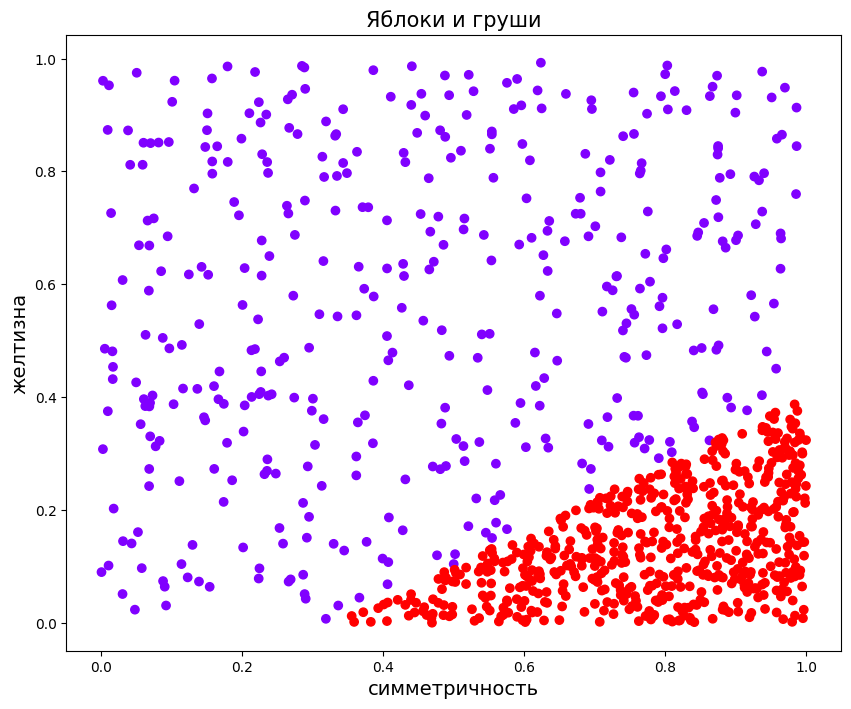

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [24]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [25]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);***

Рассмотрим второй путь (он чуть более user-friendly) и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [26]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [27]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [28]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.6884], grad_fn=<SigmoidBackward0>)

Предскажем ещё необученным нейроном:

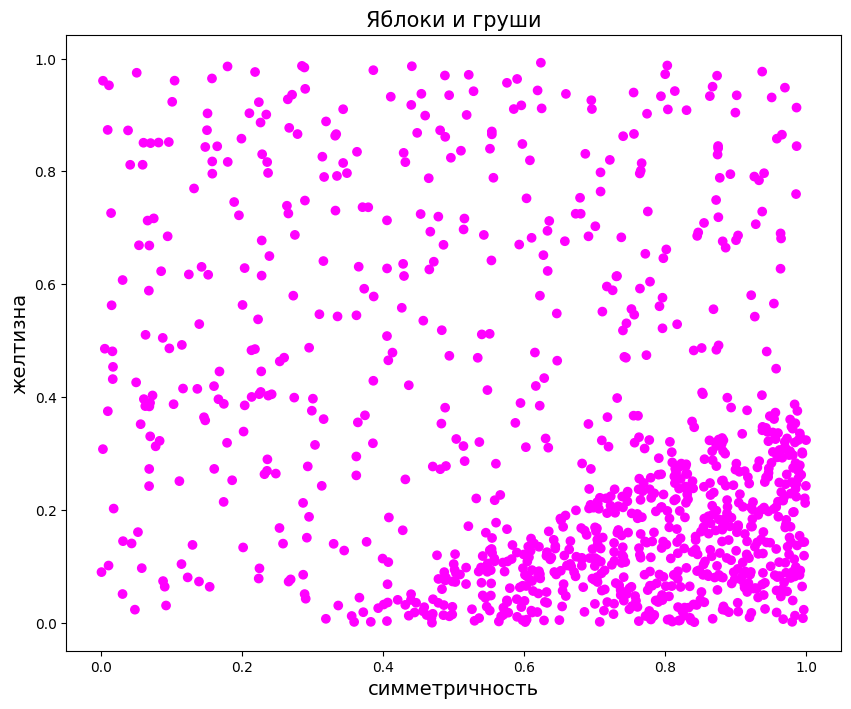

In [29]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [30]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [31]:
# квадратичная функция потерь (можно сделать другую, например, LogLoss)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию работает Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # обнуляем градиенты перед backard_pass'ом (обязательно!)
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # а тут уже обновляем веса
    optimizer.step()

0 222.2459259033203
1 215.70407104492188
2 209.98968505859375
3 205.00997924804688
4 200.64566040039062
5 196.7752227783203
6 193.29025268554688
7 190.10208129882812
8 187.14248657226562
9 184.36105346679688
10 181.7216796875
11 179.19895935058594
12 176.775146484375
13 174.4378204345703
14 172.1781768798828
15 169.9899139404297
16 167.8682098388672
17 165.80935668945312
18 163.8103485107422
19 161.86862182617188
20 159.98190307617188
21 158.14816284179688
22 156.365478515625
23 154.63206481933594
24 152.9462127685547
25 151.30624389648438
26 149.71063232421875
27 148.1578369140625
28 146.6464080810547
29 145.17489624023438
30 143.74192810058594
31 142.34620666503906
32 140.9864501953125
33 139.66143798828125
34 138.36993408203125
35 137.11082458496094
36 135.88304138183594
37 134.68544006347656
38 133.51708984375
39 132.37693786621094
40 131.26405334472656
41 130.1775665283203
42 129.1165313720703
43 128.0801544189453
44 127.06761169433594
45 126.07810974121094
46 125.11090087890625
4

c:\Users\ff3st\Desktop\ns-2\.venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Обучили. Предскажем теперь:

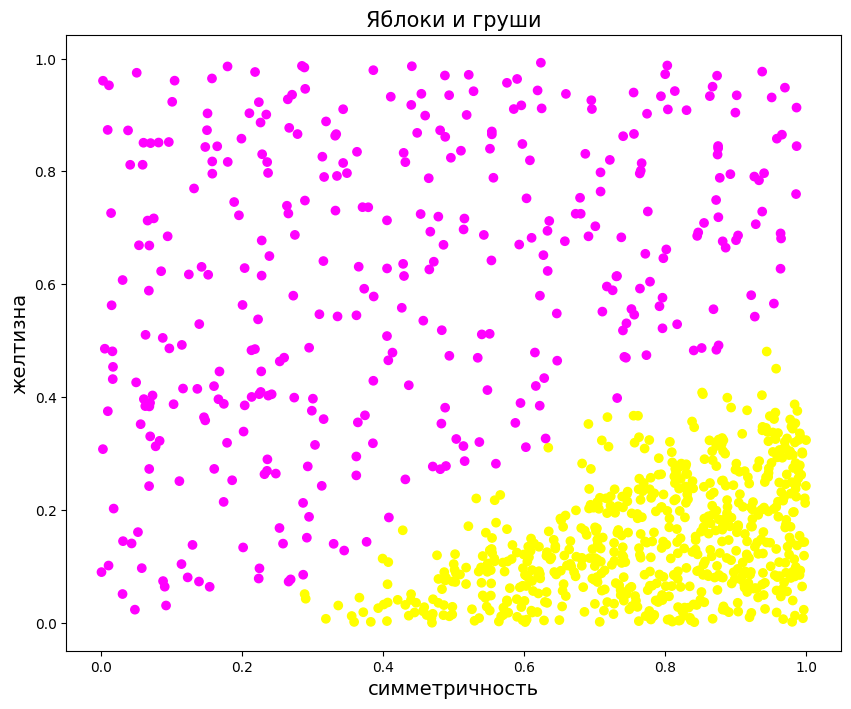

In [32]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Можно добиться лучшего качества работы путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации). Рекомендуем вам поупражняться и использовать функцию потерь `torch.nn.NLLLoss()` или `torch.nn.CrossEntropy()`.

---

Нейрон работет, отличает яблоки от груш. Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

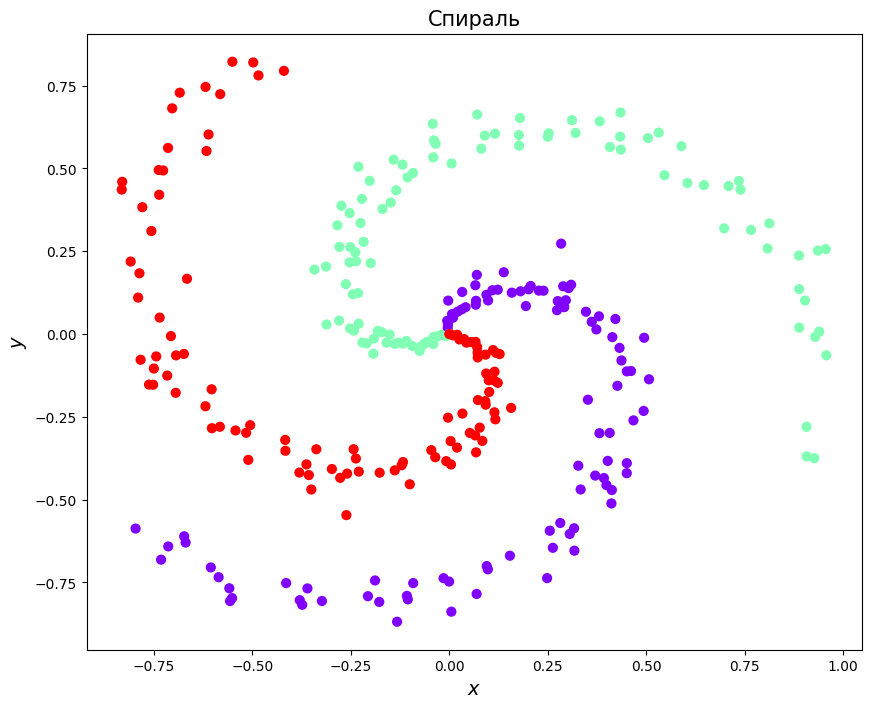

In [33]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable():

In [34]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [35]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Попробуем нейрон с сигмоидой на линейно неразделимой выборке (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [36]:
# N - размер батча (batch_size, нужно для метода оптимизации)
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса 
    optimizer.step()

0 378.5484619140625
1 378.06884765625
2 377.5914306640625
3 377.11614990234375
4 376.64306640625
5 376.1722106933594
6 375.7035827636719
7 375.237060546875
8 374.7725830078125
9 374.310302734375
10 373.8501281738281
11 373.3919982910156
12 372.9360046386719
13 372.4820556640625
14 372.0301818847656
15 371.580322265625
16 371.1324768066406
17 370.6866760253906
18 370.2428283691406
19 369.80096435546875
20 369.361083984375
21 368.9231262207031
22 368.4871826171875
23 368.05316162109375
24 367.62103271484375
25 367.1908264160156
26 366.762451171875
27 366.3360290527344
28 365.9114074707031
29 365.4887390136719
30 365.06787109375
31 364.6488037109375
32 364.23162841796875
33 363.81622314453125
34 363.402587890625
35 362.9907531738281
36 362.58074951171875
37 362.1724548339844
38 361.7658996582031
39 361.361083984375
40 360.95806884765625
41 360.5567321777344
42 360.1571350097656
43 359.75921630859375
44 359.36297607421875
45 358.9683837890625
46 358.5754699707031
47 358.18426513671875
48 3

In [37]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

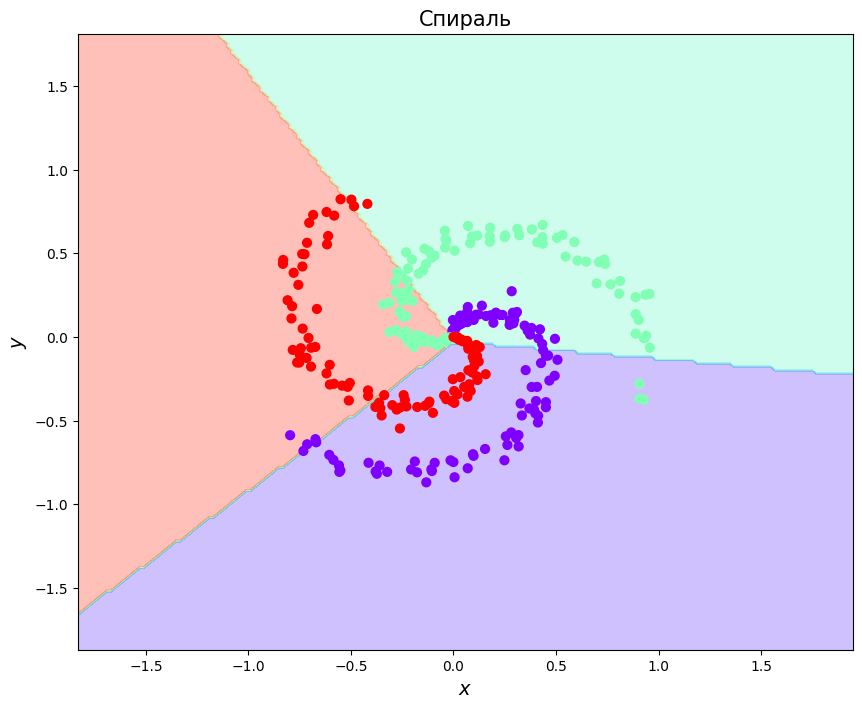

In [38]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Не слищком впечатляет. В следующей практике мы попробуем многослойную нейросеть на этой же задаче.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). *Курс Стэнфорда:  http://cs231n.github.io/*  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*